In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import matplotlib.patches as mpatches

In [2]:
def preprocess(totalLabels,stats, centroids):
    columns = ['label_id', 'left','top','width','height','area','centroid_x','centroid_y']
    df = pd.DataFrame(columns=columns)
    df['label_id'] = [i for i in range(1,totalLabels+1)]
    df['left'] = stats[:,0]
    df['top'] = stats[:,1]
    df['width'] = stats[:,2]
    df['height'] = stats[:,3]
    df['area'] = stats[:,4]
    df['centroid_x'] = centroids[:,0]
    df['centroid_y'] = centroids[:,1]
    return df

In [3]:
def preprocess_helper(df):
    df['aspect_ratio'] = np.round(df['width']/df['height'],2)
    
    df = df[(df['area'] > 50) & (df['aspect_ratio'] > 1.9) & (df['area'] < 3000)]
    df = df.sort_values(by=['top', 'left']).reset_index(drop=True)
    
    df['rowID'] = 1
    row_id = 1
    prev_val = df.loc[0, 'top']
    thresh = 10

    for idx in range(1, df.shape[0]):
        curr_val = df.loc[idx, 'top']
        if curr_val - prev_val > thresh:
            row_id += 1
        prev_val = curr_val
        df.at[idx, 'rowID'] = int(row_id)

    df['columnID'] = df.groupby('rowID')['left'].rank().astype(int)
    return df

In [4]:
def plot_components(df,comps=[]):
    output = img.copy() 
    for comp in comps:
        x, y, w, h, area = df[df['label_id'] == comp][['left','top','width','height','area']].values[0]
        cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 2)
    plt.imshow(output)

In [5]:
def plot_nn_patch(df,img,root_label, neighbor_labels):          
    output = img.copy()
    count = 0
    x,y,w,h = df[df['label_id'] == root_label][['left','top','width','height']].values[0]  
    print(df[df['label_id'] == root_label])
    cv2.rectangle(output, (x, y), (x + w, y + h),(255,0,0) , 2)
    for neighbor in neighbor_labels:
        count += 1
        x1,y1,w1,h1 = df[df['label_id'] == neighbor][['left','top','width','height']].values[0]
        cv2.rectangle(output, (x1, y1), (x1 + w1, y1 + h1),(0, 255,0) , 2)
        cv2.putText(output, str(count), (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
        #cv2.circle(output, (100, 100), 5, (255, 255, 255), -1)
    plt.imshow(output)

In [6]:
def build_single_lexicon(label_id, df, k=5):
    if label_id not in df['label_id'].values:
        print("unknown component")
        return
    x,y,w,h,r,c = df[df['label_id'] == label_id][['left','top','width','height','rowID','columnID']].values[0]
    r1 = (df['rowID'] >= r-1)
    r2 = (df['rowID'] <= r+1)    
    
    temp_df = df[r1 & r2]
    temp_df = temp_df[temp_df['label_id'] != label_id]
    
     #translation-invariance
    temp_df['new_centroid_x'] = (temp_df['centroid_x']-x)
    temp_df['new_centroid_y'] = (y-temp_df['centroid_y'])
    temp_df['new_left'] = (temp_df['left']-x)/w
    temp_df['new_top'] = (y-temp_df['top'])/w
    temp_df['new_width'] = temp_df['width']/w
    temp_df['new_height'] = temp_df['height']/w
    
    #rotation-invariance
    
    #scale-invariance
    temp_df['new_centroid_x'] = temp_df['new_centroid_x']/w
    temp_df['new_centroid_y'] = temp_df['new_centroid_y']/w
    
    #calculate metrics-distance & angle
    temp_df['Euclidean'] = np.sqrt(temp_df['new_centroid_y']**2 + temp_df['new_centroid_x']**2)
    temp_df['theta'] = np.degrees(np.arctan2(temp_df['new_centroid_y'], temp_df['new_centroid_x']))
    temp_df['theta'] = (temp_df['theta'] + 360) % 360 
    temp_df.loc[temp_df['theta'] > 350, 'theta'] = 0
    temp_df.loc[temp_df['theta'] < 2, 'theta'] = 0
    temp_df['quadrant'] = pd.cut(temp_df['theta'], 8, labels=range(1,9))
    
    #get knn
    res_df = temp_df.sort_values(by=['Euclidean','theta'])[:k]
    res_df = res_df.sort_values(by=['theta'])
    res_df['tl_corner'] = res_df.apply(lambda row: (row['new_left'], row['new_top']), axis=1)
    res_df['br_corner'] = res_df.apply(lambda row: (row['new_left']+row['new_width'], row['new_top']+row['new_height']), axis=1)           

    return res_df 

In [7]:
def build_context_layout(img):
    _,imgThresh1 = cv2.threshold(img,200,255,cv2.THRESH_BINARY)
    bs = 5
    k = -0.2
    maxval = 255
    img1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    imgThresh2 = cv2.ximgproc.niBlackThreshold(img1,maxValue=maxval,
                                               type=cv2.THRESH_BINARY,blockSize=bs,k=k)
    
    totalLabels, labels, stats, centroid = cv2.connectedComponentsWithStats(imgThresh2,4,cv2.CV_32S)
    df = preprocess(totalLabels,stats, centroid)
    df = preprocess_helper(df)
    
    print("total no of words(>3 chars) identified:",df.shape[0])
    
    context_vectors = []
    k_neigh = 5
    for label in df.label_id.values:
        try:
            res = build_single_lexicon(label, df,k=k_neigh)
            if(res.shape[0] >= k_neigh):
                context_vectors.append(res[['tl_corner','br_corner']].values)
        except Exception as e:
            print()
            
    flattened_tuples = [np.array([item for sublist in t for item in sublist]) for t in context_vectors]
    array_of_tuples = np.array(flattened_tuples)
    context_vectors = array_of_tuples.reshape(len(context_vectors), k_neigh, 4)
    #context_vectors = context_vectors.round(2)

    print("total no of contexts extracted:",context_vectors.shape[0])
    
    return context_vectors

In [8]:
def count_matches(query_vectors,doc_vectors):
    matches = np.all(query_vectors[:, np.newaxis] == doc_vectors, axis=(2, 3))
    num_matches = np.sum(matches, axis=1)
    num_matches = len(num_matches[num_matches == 1])
    return num_matches, 100*num_matches/len(query_vectors)

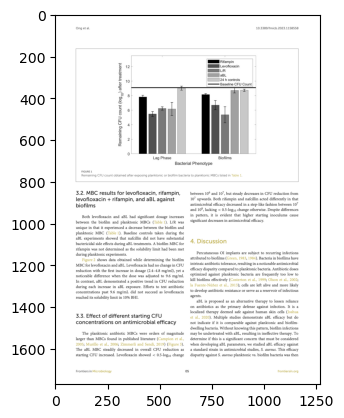

In [9]:
img_full = cv2.imread('./../../samples/imgPDF.png')
plt.imshow(img_full)

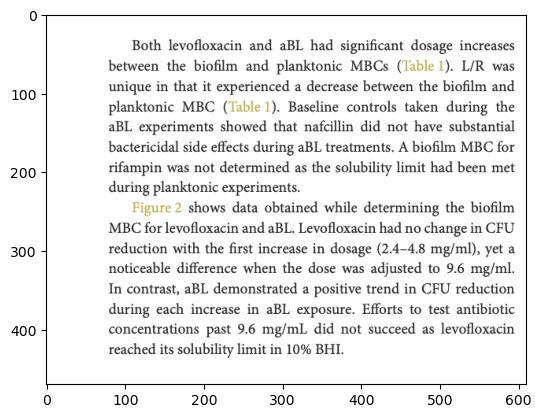

In [10]:
img = img_full[930:1400, 20:630]
plt.imshow(img)

In [11]:
query_vectors = build_context_layout(img)
len(query_vectors)

total no of words identified: 85
total no of contexts extracted: 85


85

In [12]:
doc_vectors = build_context_layout(img_full)
len(doc_vectors)

total no of words identified: 289
total no of contexts extracted: 280


280

In [13]:
count_matches(query_vectors,doc_vectors)

(82, 96.47058823529412)

In [14]:
count_matches(doc_vectors,query_vectors)

(82, 29.285714285714285)

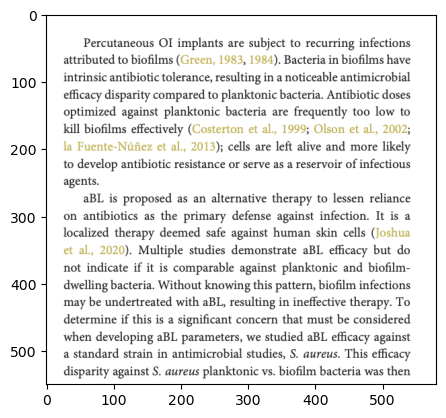

In [15]:
img21 = img_full[1100:1650, 620:1200]
plt.imshow(img21)

In [16]:
query21_vectors = build_context_layout(img21)
len(query21_vectors)

total no of words identified: 103
total no of contexts extracted: 103


103

In [17]:
count_matches(query21_vectors,doc_vectors)

(86, 83.49514563106796)

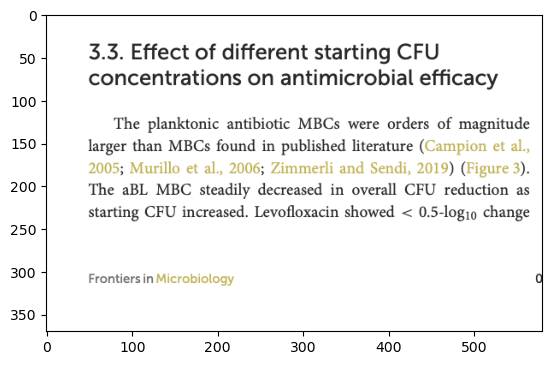

In [18]:
img31 = img_full[1400:, 50:630]
plt.imshow(img31)

In [19]:
query31_vectors = build_context_layout(img31)
len(query31_vectors)

total no of words identified: 41
total no of contexts extracted: 41


41

In [20]:
count_matches(query31_vectors,doc_vectors)

(31, 75.60975609756098)

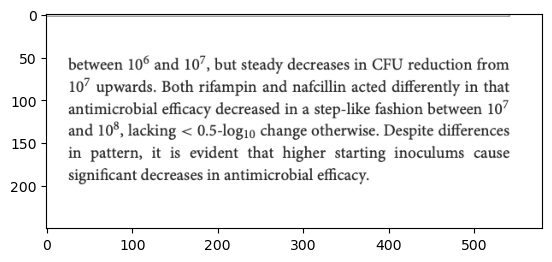

In [21]:
img41 = img_full[800:1050, 620:1200]
plt.imshow(img41)

In [22]:
query41_vectors = build_context_layout(img41)
len(query41_vectors)

total no of words identified: 30
total no of contexts extracted: 30


30

In [23]:
count_matches(query41_vectors,doc_vectors)

(23, 76.66666666666667)

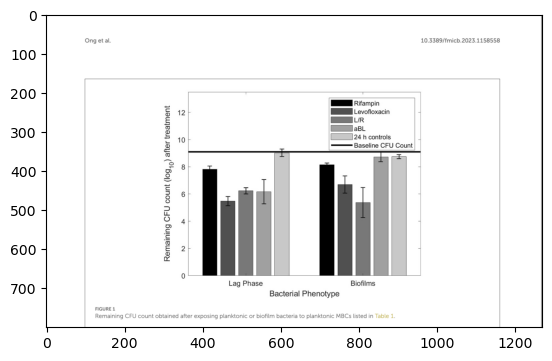

In [24]:
img51 = img_full[:800, :]
plt.imshow(img51)

In [25]:
query51_vectors = build_context_layout(img51)
len(query51_vectors)

total no of words identified: 20
total no of contexts extracted: 11


11

In [26]:
count_matches(query51_vectors,doc_vectors)

(1, 9.090909090909092)